# Model: Logistic Regression

## Imports and Setup

In [1]:
# Helper libraries
import warnings

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Local Imports
from churn_detection.evaluation import display_roc_auc_score, display_clf_report, validate_model_with_cv
from churn_detection.visualization import plot_roc_curve, plot_confusion_table
from churn_detection.data import load_data
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.utils import get_feature_names
from churn_detection.features import (add_transformation, 
                                      create_column_preprocessor,
                                      DummyNumericTransformer, 
                                      ColumnPreprocessor, 
                                      Transformation,
                                      create_pipe, 
                                      engineer_features)


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)

## Data Modeling

In [4]:
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

### Numeric Transforms

Let's add robust scaling for the highest skewed distribution, while keeping the others unchanged.

In [5]:
prep = ColumnPreprocessor()

prep.add_transformation(
    Transformation(
        name="exponential", 
        variables=["totalcharges"],
        steps=[("scaler", RobustScaler()),]
    )
)

prep.add_transformation(
    Transformation(
        name="bimodal", 
        variables=["tenure","monthlycharges"],
        steps=[("notransf", DummyNumericTransformer()),]
    )
)

prep.add_transformation(
    Transformation(
        name="discrete", 
        variables=categorical_variables,
        steps=[("encoder", OneHotEncoder(sparse_output=False, drop="if_binary")),]
    )
)

### Model Evaluation

#### Cross Validation on Full Train Set

In [6]:
prep_train, prep_test = train_test_split(
    preprocessed_data, 
    test_size=0.2, 
    random_state=1
)

X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [7]:
preprocessor = prep.create_preprocessor()

lr_pipe = create_pipe(
    preprocessor, 
    LogisticRegression(random_state=0)
)

In [8]:
mean, var = validate_model_with_cv(lr_pipe, train_data=(X_train, y_train), metric="roc_auc")
print(f"ROC AUC score with default threshold: Mean = {mean:.4f}, Var = {var:.4f}")

ROC AUC score with default threshold: Mean = 0.8420, Var = 0.0166


#### Final Score on Test Data

What interests us here for now is the % of churning users we can detect with our classifier and its default parameters.<br>
Thus essentially recall score on positive class and the deduced remaining % we fail to reach.

In [9]:
model = LogisticRegression(random_state=0)

In [10]:
transformers = prep.get_transformations()
train_features = engineer_features(X_train, transformers)
model.fit(train_features, y_train)

LogisticRegression(random_state=0)

In [11]:
# Test Data
test_features = engineer_features(X_test, transformers)
test_predictions = model.predict(test_features)
display_clf_report(test_predictions, y_test)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1061
           1       0.62      0.58      0.60       348

    accuracy                           0.81      1409
   macro avg       0.74      0.73      0.74      1409
weighted avg       0.81      0.81      0.81      1409



#### Confusion Table on Test Set

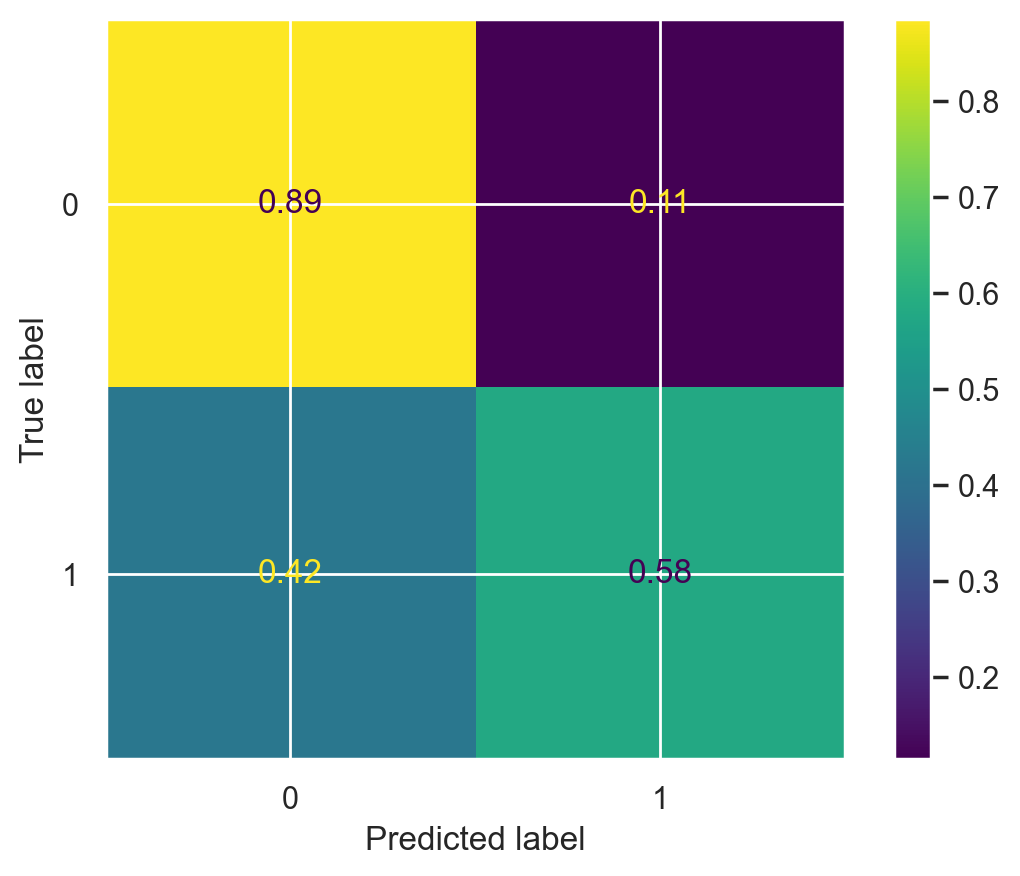

In [12]:
# Test Set
plot_confusion_table(y_test, test_predictions)

This classifier detects, on unseen data, 58% of all churned customers.